In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.ticker as mticker
import time
import matplotlib.pyplot as plt
from tsf_dataloader import convert_tsf_to_dataframe
from IPython.display import display
import datetime
import matplotlib.colors
import zoneinfo
from anomaly_generator import *

In [2]:
# Traffic hourly dataset
fn = "../data/time_series_datasets/traffic_hourly_dataset.tsf"
df = convert_tsf_to_dataframe(fn)[0]
display(df)

,series_name,start_timestamp,series_value
0,T1,2015-01-01 00:00:01,"[0.0048, 0.0072, 0.004, 0.0039, 0.0042, 0.004,..."
1,T2,2015-01-01 00:00:01,"[0.0146, 0.0148, 0.0101, 0.006, 0.0055, 0.0071..."
2,T3,2015-01-01 00:00:01,"[0.0289, 0.035, 0.0267, 0.0218, 0.0191, 0.0213..."
3,T4,2015-01-01 00:00:01,"[0.0142, 0.0174, 0.0124, 0.009, 0.0082, 0.0106..."
4,T5,2015-01-01 00:00:01,"[0.0064, 0.0084, 0.0049, 0.0029, 0.0024, 0.003..."
...,...,...,...
857,T858,2015-01-01 00:00:01,"[0.0051, 0.0036, 0.003, 0.0033, 0.0049, 0.0107..."
858,T859,2015-01-01 00:00:01,"[0.0339, 0.0348, 0.0327, 0.0292, 0.0264, 0.025..."
859,T860,2015-01-01 00:00:01,"[0.0051, 0.0036, 0.003, 0.0033, 0.0049, 0.0107..."
860,T861,2015-01-01 00:00:01,"[0.01, 0.0087, 0.0061, 0.004, 0.004, 0.0038, 0..."


In [3]:
timeseries = list(df["series_value"].apply(lambda x: list(x)))
timeseries = np.array(timeseries)

# setting up an array of timestamps
start_time = df['start_timestamp'][0]
start_timestamp = time.mktime(start_time.timetuple())
time_interval = 60*60 # hourly
timeseries_len = timeseries.shape[1]
timestamp_arr = np.arange(int(start_timestamp), int(start_timestamp)+time_interval*timeseries_len, time_interval)
time_arr = np.array([datetime.datetime.utcfromtimestamp(int(float(timestamp))).replace(tzinfo=datetime.timezone.utc).astimezone(tz=zoneinfo.ZoneInfo(key="America/Los_Angeles")).strftime('%Y-%m-%d') for timestamp in timestamp_arr])
weekdays_timestamps = np.array([datetime.datetime.utcfromtimestamp(int(float(timestamp))).replace(tzinfo=datetime.timezone.utc).astimezone(tz=zoneinfo.ZoneInfo(key="America/Los_Angeles")).weekday() for timestamp in timestamp_arr])

In [56]:
def plot_timeseries(timeseries, time_arr, weekdays, scale=1, total_time=60*60*24*7, time_interval=60*60):

    # make figure + axes
    fig, ax = plt.subplots(tight_layout=True, figsize=(15,5))
    plt.title("Hourly Traffic Data")
    ax.set_xlabel('date')
    ax.set_ylabel(f'Occupancy Percent')

    rand_ind = np.random.randint(0, timeseries.shape[0], 6)
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'pink', 'gray', 'lime', 'magenta', 'teal']
    if timeseries.ndim == 2:
        for i in range(timeseries.shape[0]):
            ax.plot(timeseries[i]/scale, c=colors[i%len(colors)], lw=0.5)
    else:
        ax.plot(timeseries[i]/scale, c='blue', lw=1)

    cut_time_arr = time_arr
    # helper function for the formatter
    def listifed_formatter(x, pos=None):
        try:
            return cut_time_arr[int(x)]
        except IndexError:
            return ''
        
    cut_weekdays = weekdays
    Z = np.repeat(cut_weekdays.reshape(1,cut_weekdays.shape[0]),int(ax.get_ylim()[1]+1),axis=0).reshape(int(ax.get_ylim()[1]+1),cut_weekdays.shape[0])
    cvals = [0,1,2,3,4,5,6]
    colors = ['y','y','y','y','y','b','b']
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
    X=np.repeat(np.expand_dims(np.arange(total_time//time_interval+1),0), 2, axis=0).reshape([2,total_time//time_interval+1])
    Y=np.zeros((total_time//time_interval+1)*2).reshape([2,total_time//time_interval+1])
    Y[1] = ax.get_ylim()[1]
    c = ax.pcolor(X, Y, Z, alpha=0.1, edgecolor=None, snap=True, cmap=cmap) 
    ax.vlines(np.where(cut_weekdays[:-1] != cut_weekdays[1:])[0]+1,0,ax.get_ylim()[1], colors='black', linewidth=0.1)

    # make and use the formatter
    mt = mticker.FuncFormatter(listifed_formatter)
    ax.xaxis.set_major_formatter(mt)

    # set the default ticker to only put ticks on the integers
    loc = ax.xaxis.get_major_locator()
    loc.set_params(integer=True)

    # rotate the labels
    [lab.set_rotation(15) for lab in ax.get_xticklabels()]
    plt.show()

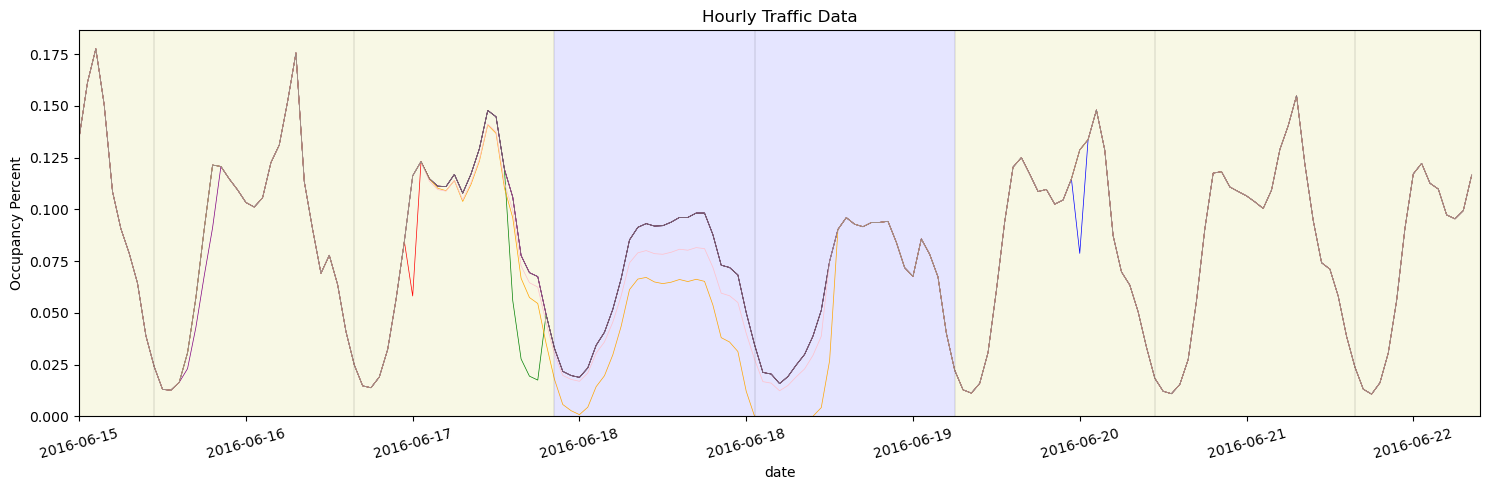

In [57]:
# rand_ind = np.random.randint(0, timeseries.shape[0], 6)
rand_ind = np.array([np.random.randint(0,timeseries.shape[0])]*7)
total_time = 60*60*24*7
start_date = np.random.randint(0,timeseries_len-total_time//time_interval)
cut_time_arr = time_arr[start_date:start_date+total_time//time_interval]
cut_weekend = weekdays_timestamps[start_date:start_date+total_time//time_interval]
# draw one line
selected_timeseries = timeseries[rand_ind, start_date:start_date+total_time//time_interval]
gen_add_anomaly(selected_timeseries[0], -0.05, min_val=0) # blue
gen_mult_anomaly(selected_timeseries[1], 0.5, min_val=0) # red
gen_sustained_add(selected_timeseries[2], -0.05, min_val=0) # green
gen_sustained_mult(selected_timeseries[3], 0.75, min_val=0) # purple
gen_bleed_add(selected_timeseries[4], -0.001, -0.001, len_anomaly=48, min_val=0) # orange
gen_bleed_mult(selected_timeseries[5], 0.99, -0.005, len_anomaly=48, min_val=0) # pink
# Normal grey

plot_timeseries(selected_timeseries, cut_time_arr, cut_weekend, total_time=total_time)